# 1. بارگذاری کتابخانه‌ها  

In [1]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchsummary

import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
import torchaudio.transforms as T
import torchaudio.functional as AF

from torch.nn.utils.rnn import pad_sequence as torch_pad_sequence

import numpy as np
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from tqdm import tqdm
import os

from IPython.display import Audio

# 2. آماده‌سازی دیتاست  


In [ ]:
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

train_set = SubsetSC("training")
valid_set = SubsetSC("validation")
test_set = SubsetSC("testing")

100%|██████████| 2.26G/2.26G [01:44<00:00, 23.3MB/s]


In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in valid_set)))
print(labels)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
num_cls = len(labels)
print(num_cls)
print(device)

In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

In [ ]:
def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch_pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

In [ ]:
def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

In [ ]:
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
#
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory)
#
valid_loader = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory)
#
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory)

# 3. M5 تعریف مدل   
[Very Deep Convolutional Neural Networks for Raw Waveforms](https://arxiv.org/pdf/1610.00087.pdf)

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x

In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

# 4. آموزش‌ مدل  


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task="multiclass", num_classes=len(labels)).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.squeeze(1), targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()


      loss_train.update(loss.item())
      acc_train(outputs.squeeze(1), targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())

  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=len(labels)).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs.squeeze(1), targets)

      loss_valid.update(loss.item())
      acc_valid(outputs.squeeze(1), targets.int())

  return loss_valid.avg, acc_valid.compute().item()

In [ ]:
model = M5(n_input=1, n_output=num_cls).to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 3

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                   epoch)
  scheduler.step()
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 332/332 [05:01<00:00,  1.10batch/s, accuracy=87.4, loss=0.43]


Valid: Loss = 0.5009, Acc = 0.8544



Epoch 1: 100%|██████████| 332/332 [04:57<00:00,  1.11batch/s, accuracy=87.6, loss=0.426]


Valid: Loss = 0.576, Acc = 0.8313



Epoch 2:  99%|█████████▉| 330/332 [05:08<00:01,  1.22batch/s, accuracy=87.8, loss=0.415]


Model Saved!
Valid: Loss = 0.4838, Acc = 0.8555



# 5. ارزیابی و نمودارها  


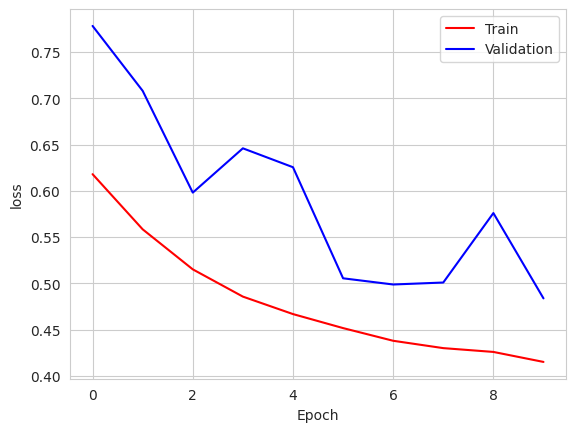

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

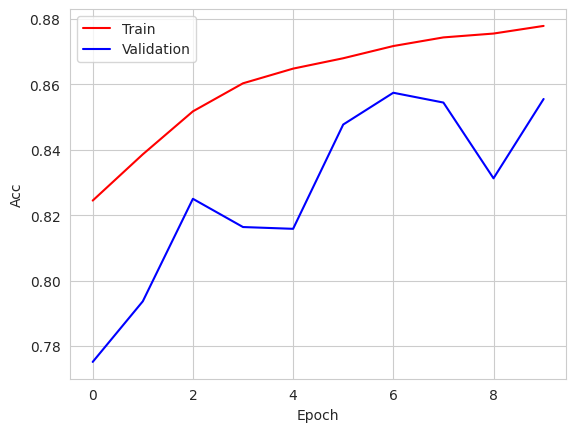

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

In [ ]:
def test_model(model, data_loader):
    model.to(device)
    model.eval()
    acc_valid = Accuracy(task="multiclass", num_classes=num_cls).to(device)

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            acc_valid.update(outputs.squeeze(1), targets)

    return acc_valid.compute().item()


In [ ]:
test_model(model, test_loader)

0.8555201888084412

In [ ]:
torchsummary.summary(model,(1, 16000), 256)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [256, 32, 996]           2,592
       BatchNorm1d-2             [256, 32, 996]              64
         MaxPool1d-3             [256, 32, 249]               0
            Conv1d-4             [256, 32, 247]           3,104
       BatchNorm1d-5             [256, 32, 247]              64
         MaxPool1d-6              [256, 32, 61]               0
            Conv1d-7              [256, 64, 59]           6,208
       BatchNorm1d-8              [256, 64, 59]             128
         MaxPool1d-9              [256, 64, 14]               0
           Conv1d-10              [256, 64, 12]          12,352
      BatchNorm1d-11              [256, 64, 12]             128
        MaxPool1d-12               [256, 64, 3]               0
           Linear-13               [256, 1, 35]           2,275
Total params: 26,915
Trainable params: 